# Определение рейтинга шоколада

Проект является решением для соревнования https://www.kaggle.com/competitions/practical-ml-chocolate/overview  в рамках курса "Практический Machine Learning" https://stepik.org/course/125501/info

Решается задача определения рейтинга шоколада. Датасет содерхжит информацию о следующих характеристиках шоколадок:

- Company - компания производитель
- Specific Bean Origin - географический регион происхождения
- REF - параметр, определяющий момент внесения записи в базу данных (чем выше значение, тем "свежее" запись)
- Review - дата публикации отзыва
- Cocoa Percent - процентное содержание какао
- Company Location - страна производитель
- Rating - экспертный рейтинг
- Bean Type - используемый сорт какао-бобов, если таковой имеется
- Broad Bean Origin - географический регион происхождения какао-бобов

Система рейтинга шоколада:
- 5 = Elite
- 4 = Premium
- 3 = Satisfactory(3.0) to praiseworthy(3.75)
- 2 = Disappointing
- 1 = Unpleasant

**Никнейм на Kaggle**: Alena Kniazeva (https://www.kaggle.com/alenakn)

**Достигнутый score на тестовых данных**: ...

## 1. Импорт библиотек и загрузка данных

In [1]:
#!pip install association-metrics

In [2]:
#!pip install category_encoders

In [3]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

import optuna
from sklearn.pipeline import Pipeline

import association_metrics as am

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from catboost import CatBoostRegressor

from sklearn.model_selection import KFold

from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore") 

C:\Users\alena\AppData\Local\Temp\ipykernel_10776\3942007263.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\alena\.virtualenvs\practical_ml-ylDaoyg-\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
RANDOM_STATE=42
N_FOLDS = 5

In [5]:
TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"

In [6]:
train_df = pd.read_csv(TRAIN)

## 2. Исследовательский анализ данных

In [7]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


Обработаем признак `Cocoa Percent`: удалим знак процента и преобразуем к вещественному типу

In [8]:
train_df['Cocoa Percent'] = train_df['Cocoa Percent'].map(lambda x: x.rstrip('%'))
train_df['Cocoa Percent'] = train_df['Cocoa Percent'].astype('float64')

Видим, что признак `Bean Type` для некоторых объектов отсутствует. Проверим, каким значением представлены эти пропуски и заменим во всем датафрейме это значение на строку "Unknown"

In [9]:
str(train_df.loc[2, ['Bean Type']])

'Bean Type    \xa0\nName: 2, dtype: object'

In [10]:
train_df = train_df.replace(to_replace=u'\xa0', value='Unknown')

Проверим общую информацию о тренировочном датасете

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   float64
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1254 non-null   object 
 8   Broad Bean Origin     1254 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 88.4+ KB


Обучающий датасет содержит **1255 объектов**, **8 признаков**, а также целевую переменную - `Rating`.

Из 8 признаков **3 имеют численные значние**, остальные **5 - текстовые**.

Целевая переменная - **вещественная**. Т.о. решаем задачу регрессии

В признаках `Bean Type` и `Broad Bean Origin` есть по одному пропуску. Чтобы не терять эти данные заменим пропущенные значения на строку "Unknown"

In [13]:
train_df.fillna('Unknown', inplace=True)

### 2.1. Исследование числовых признаков

Проверим корреляцию числовых признаков с таргетом

In [14]:
num_features = ['REF', 'Review', 'Cocoa Percent', 'Rating']
corr = train_df[num_features].corr()
corr.style.background_gradient(cmap='coolwarm')

,REF,Review,Cocoa Percent,Rating
REF,1.000000,0.984938,0.045015,0.112792
Review,0.984938,1.000000,0.045322,0.111826
Cocoa Percent,0.045015,0.045322,1.000000,-0.172411
Rating,0.112792,0.111826,-0.172411,1.000000


Видим, что числовые признаки слабо коррелируют с целевой переменной.

При этом сильно коррелируют признаки `REF` и `Review`. **Будем учитывать это при построении моделей  либо при необходимости удалим один из этих признаков**.

Проверим числовые признаки и целевую переменную на наличие выбросов. Построим boxplots

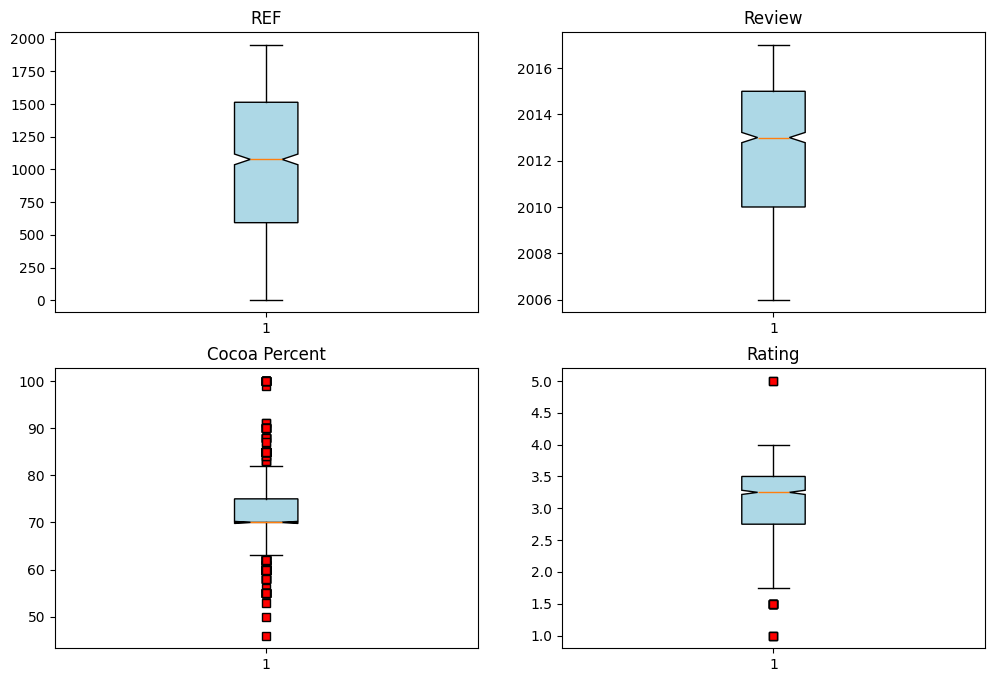

In [15]:
fig, a = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.2)

for i in range(2):
    for j in range(2):
        a[i][j].set_title(num_features[i*2+j])
        a[i][j].boxplot(train_df[num_features[i*2+j]], 
                        notch = True, 
                        flierprops = dict(marker = "s", markerfacecolor = "red"), 
                        patch_artist = True, 
                        boxprops = dict(facecolor = "lightblue")) 

При том,что по признаку `Cocoa Percent` и целевой переменной есть выбросы, их нельзя назвать аномалиями, т.к. они находятся в допустимых пределах. Поэтому пока что ничего удалять не будем

В рамках данного проекта будем работать с бустинговыми моделями поэтому **не будем выполнять масштабирование данных**, т.к. модели на основе деревьев нечувствительны к масштабированию

### 2.2. Исследование с текстовыми данными

Проверим количество уникальных значений в признаках с типом `object`

In [16]:
train_df.describe(include='object')

,Company,Specific Bean Origin,Company Location,Bean Type,Broad Bean Origin
count,1255,1255,1255,1255,1255
unique,376,762,58,38,84
top,Soma,Madagascar,U.S.A.,Unknown,Venezuela
freq,35,39,521,629,144


Проверим корреляцию категориальных/текстовых признаков. В качестве показателя применим V-меру Крамера

In [17]:
cat_df = train_df.apply(
        lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(cat_df)

cramersv.fit()

,Company,Specific Bean Origin,Company Location,Bean Type,Broad Bean Origin
Company,1.000000,0.771074,0.999651,0.616841,0.603604
Specific Bean Origin,0.771074,1.000000,0.808500,0.907956,0.983377
Company Location,0.999651,0.808500,1.000000,0.291616,0.383218
Bean Type,0.616841,0.907956,0.291616,1.000000,0.388127
Broad Bean Origin,0.603604,0.983377,0.383218,0.388127,1.000000


Из полученных результатов видим, что **категориальные признаки достаточно сильно взаимосвязаны**, особенно `Company` и `Company Location`

В паре признаков  `Company` и `Company Location` сложно однозначно определить, что имеет большее значение: конкретный производитель или достаточно того, в какой стране компания-производитель находится. Построим 2 графика распраделения рейтинга в зависимости от остальных данных, выделив цветом объекты на одном графике по признаку `Company Location`, на втором - по признаку `Company`

In [18]:
y_train = train_df['Rating']
X_train = train_df.drop('Rating', axis=1)

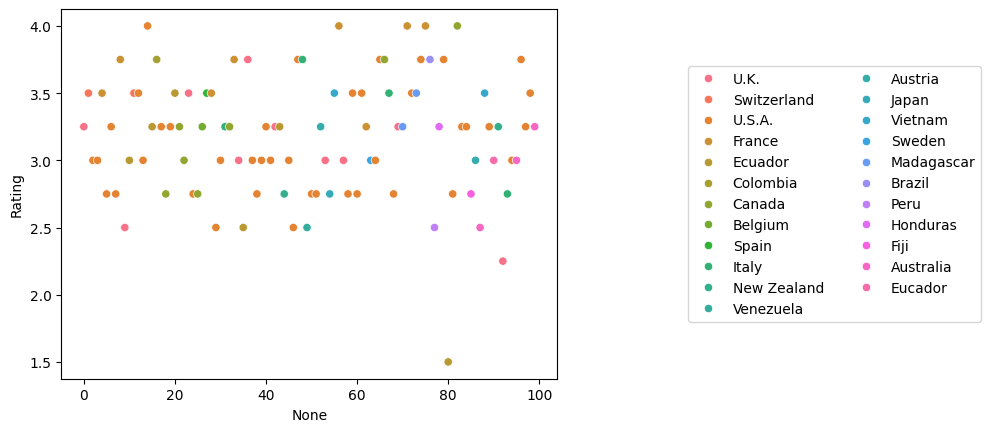

In [19]:
import seaborn as sns

g = sns.scatterplot(data=train_df.iloc[:100], x=X_train.iloc[:100].index, y=y_train[:100], hue='Company Location')
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=2)

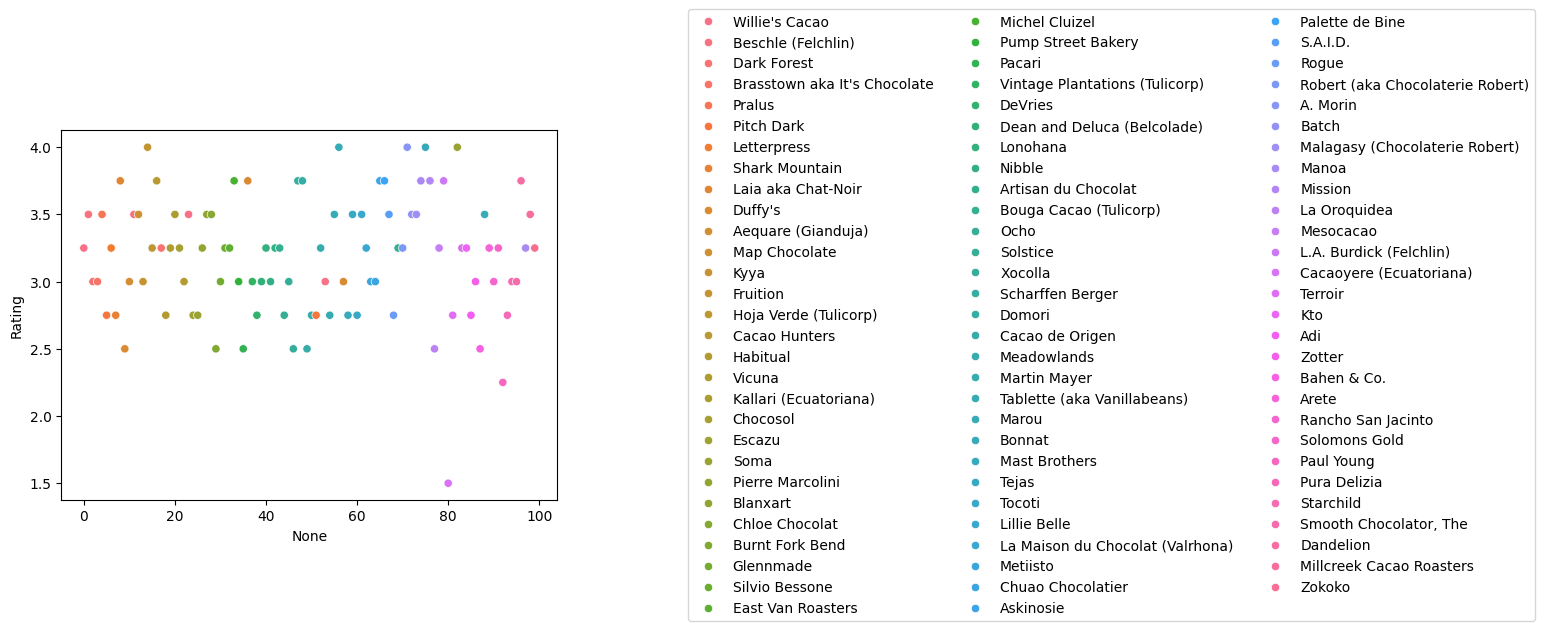

In [20]:
g2 = sns.scatterplot(data=train_df.iloc[:100], x=X_train.iloc[:100].index, y=y_train[:100], hue='Company')
g2.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=3)

Из полученных результатов видим, что по признаку `Company` данные разделяются гораздо лучше, но и для признака `Company Location` тоже можно увидеть некоторые тенденции (например, достаточно "кучный" рейтинг шведского шоколада). Но при этом количество значений у данного признака (376 значений) значительно превышает количество значений для признака `Company Location` (56 значений). С учетом отмеченного оставим пока оба признака, несмотря на их сильную взаимосвязь

Также следует отметить, что **в данном проекте будем в основном применять бустинговые модели**, которые являются достаточно устойчивыми к коррелирующим признакам.

Проверим распределение целевой переменной

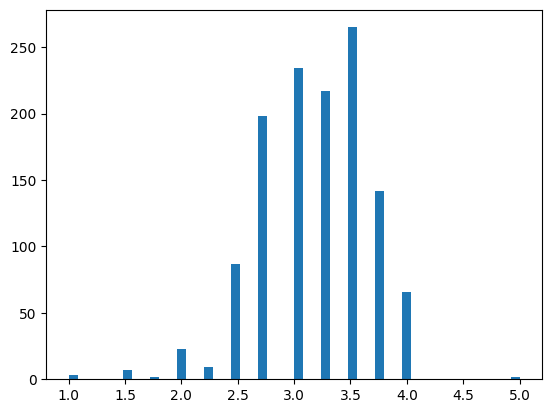

In [21]:
plt.hist(y_train, bins=50);

Полученное распределение в целом напоминает нормальное, так что дополнительных преобразований делать не надо

## 3. Обучение моделей

### 3.1. Baseline модель (CatBoost c параметрами по умолчанию)

Определим, какие признаки будем считать категориальными. Сначала выведем типы данных признаков

In [22]:
X_train.dtypes

Company                  object
Specific Bean Origin     object
REF                       int64
Review                    int64
Cocoa Percent           float64
Company Location         object
Bean Type                object
Broad Bean Origin        object
dtype: object

Все признаки с типом `object` отнесем к категориальным. У признака `REF` достаточно много значений и его целесообразно отнести к численным. Признаки `Review` и `Cocoa Percent` могут рассматриваться также как категориальные. Создадим 4 набора индексов категориальных признаков (с/без `Review` и `Cocoa Percent`) и проверим качество baseline модели (в качестве таковой возьмем CatBoost c большинством параметров по умолчанию) на этих 4 наборах категориальных признаков

Единственная особенность состоит в том, что категориальными признаками в CatBoost могут быть либо тескстовые данные, либо целые числа. Поэтому умножим `Cocoa Percent` на 10 и преобразуем в целочисленные данные

In [25]:
X_train['Cocoa Percent'] = (X_train['Cocoa Percent'] * 10).astype('int64')

In [26]:
cat_features_index = []
# Review и Cocoa Percent категориальные
cat_features_index.append([0, 1, 3, 4, 5, 6, 7])
# Review категориальный, Cocoa Percent - нет
cat_features_index.append([0, 1, 3, 5, 6, 7])
# Review не категориальный, Cocoa Percent - категориальный
cat_features_index.append([0, 1, 4, 5, 6, 7])
# Review и Cocoa Percent не категориальные
cat_features_index.append([0, 1, 5, 6, 7])

In [27]:
for indexes in cat_features_index:
    model_catboost_default = CatBoostRegressor(cat_features=indexes, random_seed=RANDOM_STATE, logging_level='Silent', eval_metric='R2')
    score = cross_val_score(model_catboost_default, X_train, y_train, cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE), 
                            scoring='r2', verbose=0).mean()
    print(f'Cross-validation score for cathegorical indexes {indexes} is equal to {score}')

Cross-validation score for cathegorical indexes [0, 1, 3, 4, 5, 6, 7] is equal to 0.1511009214307972
Cross-validation score for cathegorical indexes [0, 1, 3, 5, 6, 7] is equal to 0.207048890746352
Cross-validation score for cathegorical indexes [0, 1, 4, 5, 6, 7] is equal to 0.1508126971425096
Cross-validation score for cathegorical indexes [0, 1, 5, 6, 7] is equal to 0.19926953998207708


Из полученных результатов видим, что включение помимо текстовых признаков в категориальные признаки `Review` несколько улучшить модель. В остальных случаях она хуже

Зафиксируем категориальные признаки, обучим baseline модель (CatBoost c параметрами по умолчанию) и проверим ее качество на тестовых данных

In [28]:
cat_features_index = [0, 1, 3, 5, 6, 7]
cat_features = list(X_train.columns[cat_features_index])

In [29]:
model_catboost_default = CatBoostRegressor(cat_features=cat_features_index, random_seed=RANDOM_STATE, logging_level='Silent', eval_metric='R2')
model_catboost_default.fit(X_train, y_train)

Выполним **предобработку тестовых данных**

In [30]:
X_test = pd.read_csv(TEST)
# обрабатываем 'Cocoa Percent' и переводим в числовой формат
X_test['Cocoa Percent'] = X_test['Cocoa Percent'].map(lambda x: x.rstrip('%'))
X_test['Cocoa Percent'] = X_test['Cocoa Percent'].astype('float64')
# обрабатываем пропуски
X_test = X_test.replace(to_replace=u'\xa0', value='Unknown')
# обрабатываем 'Cocoa Percent' (для единообразия)
X_test['Cocoa Percent'] = (X_test['Cocoa Percent'] * 10).astype('int64')

In [31]:
pred = model_catboost_default.predict(X_test)

In [32]:
test_df = X_test.copy()
test_df['id'] = np.arange(len(test_df))
test_df['Rating'] = pred
test_df[['id','Rating']].to_csv("catboost_default.csv", index=False)

**R2_score на тестовой выборке 0.18184**

Улучшим модель путем подбора гиперпараметров

### 3.2. CatBoost с подбором гиперпараметров

Подберем параметры для CatBoost при помощи Optuna

In [33]:
X_tr, X_v, y_tr, y_v = train_test_split(X_train, y_train, random_state=RANDOM_STATE, test_size=0.2)

In [34]:
def objective_catboost(trial):
    cb_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1),
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'n_estimators': trial.suggest_int('n_estimators', 200, 700),
        'min_child_samples': trial.suggest_int('min_child_samples', 50, 300),
        'subsample':trial.suggest_float('subsample', 0.1, 1),
        'cat_features': cat_features_index,
        'use_best_model': True,
        'random_seed': RANDOM_STATE,
        'logging_level': 'Silent',
        'eval_metric': 'R2'
    }
    
    model = CatBoostRegressor(**cb_params)
    model.fit(X_tr, y_tr, eval_set=(X_v, y_v), verbose=False)
    y_pred = model.predict(X_v)
    return r2_score(y_v, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=30)

[I 2024-02-10 22:59:52,438] A new study created in memory with name: no-name-6191e66a-fcea-4304-a145-1e0935ad09b2
[I 2024-02-10 23:01:23,356] Trial 0 finished with value: 0.16055110977806752 and parameters: {'learning_rate': 0.9935899089650958, 'max_depth': 14, 'n_estimators': 243, 'min_child_samples': 181, 'subsample': 0.7787680562519584}. Best is trial 0 with value: 0.16055110977806752.
[I 2024-02-10 23:01:41,012] Trial 1 finished with value: 0.18890927564689075 and parameters: {'learning_rate': 0.4463338078278227, 'max_depth': 10, 'n_estimators': 413, 'min_child_samples': 109, 'subsample': 0.16403776283290022}. Best is trial 1 with value: 0.18890927564689075.
[I 2024-02-10 23:01:47,606] Trial 2 finished with value: 0.1727396616190956 and parameters: {'learning_rate': 0.38710815680274147, 'max_depth': 3, 'n_estimators': 683, 'min_child_samples': 152, 'subsample': 0.5064772911909384}. Best is trial 1 with value: 0.18890927564689075.
[I 2024-02-10 23:01:57,122] Trial 3 finished with va

In [35]:
study.best_params

{'learning_rate': 0.11350665681546111,
 'max_depth': 8,
 'n_estimators': 406,
 'min_child_samples': 196,
 'subsample': 0.5719799748437518}

Примем эти параметры, умножив 'n_estimators' на 10 и разделив 'learning_rate' на 10

In [42]:
cb_params = {
    'learning_rate': 0.011350665681546111,
    'max_depth': 8,
    'n_estimators': 4060,
    'min_child_samples': 196,
    'subsample': 0.5719799748437518,
    'cat_features': cat_features_index,
    'use_best_model': True,
    'random_seed': RANDOM_STATE,
    'logging_level': 'Silent',
    'eval_metric': 'R2'
}

Построим модель с применением CatBoost с подобранными параметрами и стэкинга 

In [43]:
folds = KFold(n_splits=N_FOLDS, random_state=RANDOM_STATE, shuffle=True)
test_catboost_preds = np.empty((N_FOLDS, len(X_test)))
r2_catboost_vals=[]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
    
    X_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
    
    CB=CatBoostRegressor(**cb_params)
    CB.fit(X_tr, y_tr,
        eval_set=[(X_val, y_val)], verbose=False)
    
    y_pred_val = CB.predict(X_val)
    r2_val = r2_score(y_val, y_pred_val)
    print("R2 for fold ",n_fold,": ",r2_val)
    r2_catboost_vals.append(r2_val)
    
    y_pred_test = CB.predict(X_test)
    test_catboost_preds[n_fold, :] = y_pred_test
    print("----------------")

R2 for fold  0 :  0.20803458451984724
----------------
R2 for fold  1 :  0.14506666853789885
----------------
R2 for fold  2 :  0.31820692770928527
----------------
R2 for fold  3 :  0.19294003825035988
----------------
R2 for fold  4 :  0.18415773039771155
----------------


In [44]:
"Mean R2: ",np.mean(r2_catboost_vals)

('Mean R2: ', 0.20968118988302056)

In [45]:
y_pred_catboost = test_catboost_preds.mean(axis=0)

In [46]:
test_df = X_test.copy()
test_df['id'] = np.arange(len(test_df))
test_df['Rating'] = y_pred_catboost

In [48]:
test_df[['id','Rating']].to_csv("catboost_optuna.csv", index=False)

**R2_score на тестовой выборке 0.21911**

Посмотрим, какие результаты дадут другие бустинговые модели

### 3.3. LightGBM

In [78]:
from lightgbm import LGBMRegressor

Определим категориальные переменные, присвоив им тип 'category'

In [79]:
X_train_gb = X_train.copy()
X_test_gb = X_test.copy()

for c in cat_features:
    X_train_gb[c] = X_train_gb[c].astype('category')
    X_test_gb[c] = X_test_gb[c].astype('category')

Проверим, как LightGBM сработает на кросс-валидации на обучающих данных

In [80]:
cross_val_score(LGBMRegressor(random_state=RANDOM_STATE, verbose=-1), X_train_gb, y_train, 
                cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE), scoring='r2', verbose=2).mean()

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


0.08964343040115959

Результат значительно хуже, чем у baseline модели CatBoost. 

Можно предположить, что это обусловлено тем, что алгоритмы кодирования категориальных признаков, реализованные в CatBoost сработали на рассматриваемом датасете эффективнее, чем те, что заложены в LightGBM

Попробуем выполнить кодировку категориальных признаков и затем передавать их в модель. Рассмотрим несколько вариантов кодировщиков

In [81]:
from category_encoders.target_encoder import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.cat_boost import CatBoostEncoder

In [82]:
from sklearn.pipeline import Pipeline

In [83]:
p1 = Pipeline([
    ('encoder_', TargetEncoder(cols=cat_features)),
    ('model_', LGBMRegressor(verbose=-1))
    ])

In [84]:
p2 = Pipeline([
    ('encoder_', OneHotEncoder(cols=cat_features)),
    ('model_', LGBMRegressor(verbose=-1))
    ])

In [85]:
p3 = Pipeline([
    ('encoder_', CatBoostEncoder(cols=cat_features)),
    ('model_', LGBMRegressor(verbose=-1))
    ])

In [86]:
for p in [p1, p2, p3]:
    score = cross_val_score(p, X_train, y_train, cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE), 
                            scoring='r2', verbose=0).mean()
    print(f'Mean score for pipeline {p} = {score}')

Mean score for pipeline Pipeline(steps=[('encoder_',
                 TargetEncoder(cols=['Company', 'Specific Bean Origin',
                                     'Review', 'Company Location', 'Bean Type',
                                     'Broad Bean Origin'])),
                ('model_', LGBMRegressor(verbose=-1))]) = 0.029247314957815917
Mean score for pipeline Pipeline(steps=[('encoder_',
                 OneHotEncoder(cols=['Company', 'Specific Bean Origin',
                                     'Review', 'Company Location', 'Bean Type',
                                     'Broad Bean Origin'])),
                ('model_', LGBMRegressor(verbose=-1))]) = 0.09498835974665458
Mean score for pipeline Pipeline(steps=[('encoder_',
                 CatBoostEncoder(cols=['Company', 'Specific Bean Origin',
                                       'Review', 'Company Location',
                                       'Bean Type', 'Broad Bean Origin'])),
                ('model_', LGBMRegresso

Качество моделей по-прежнему плохое

Применим следующий подход: закодируем категориальные признаки через TfidfVectorizer и уменьшим размерность с помощью TruncatedSVD

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [89]:
def get_vectors(df_train, df_test, col_name):
    vectorizer = TfidfVectorizer(max_features=1000)
    vectors_train = vectorizer.fit_transform(df_train[col_name])
    vectors_test = vectorizer.transform(df_test[col_name])
    
    svd = TruncatedSVD(3)
    x_pca_train = svd.fit_transform(vectors_train)
    x_pca_test = svd.transform(vectors_test)

    # Convert to DataFrames
    tfidf_df_train = pd.DataFrame(x_pca_train)
    tfidf_df_test = pd.DataFrame(x_pca_test)

    # Naming columns in the new DataFrames
    cols = [(col_name + "_tfidf_" + str(f)) for f in tfidf_df_train.columns.to_list()]
    tfidf_df_train.columns = cols
    tfidf_df_test.columns = cols

    # Reset the index of the DataFrames before concatenation
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # Concatenate transformed features with original data
    df_train = pd.concat([df_train, tfidf_df_train], axis="columns")
    df_test = pd.concat([df_test, tfidf_df_test], axis="columns")
    return df_train, df_test

In [94]:
XX_train = X_train.copy()
XX_test = X_test.copy()

text_features = ['Company', 'Specific Bean Origin', 'Company Location', 'Bean Type', 'Broad Bean Origin']

for feat in text_features:
    XX_train, XX_test = get_vectors(XX_train, XX_test, feat)
    XX_train.drop(feat, axis=1, inplace=True)
    XX_test.drop(feat, axis=1, inplace=True)

Проверим качество модели LGBMRegressor по кросс-валидации на обработанных таким образом данных

In [95]:
cross_val_score(LGBMRegressor(verbose=-1), XX_train, y_train, 
                cv=KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE), scoring='r2', verbose=2).mean()

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


0.16738991637955808

Качество значительно улучшилось. Подберем гипермараметры с помощью Optuna

In [96]:
XX_tr, XX_v, y_tr, y_v = train_test_split(XX_train, y_train, random_state=RANDOM_STATE, test_size=0.2)

In [97]:
def objective_lgbm(trial):
    lgb_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1),
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'n_estimators': trial.suggest_int('n_estimators', 200, 700),
        'min_child_samples': trial.suggest_int('min_child_samples', 50, 300),
        'subsample':trial.suggest_float('subsample', 0.1, 1),
        'use_best_model': True,
        'verbose': -1
    }
    
    model = LGBMRegressor(**lgb_params)
    model.fit(XX_tr, y_tr, eval_set=(XX_v, y_v), eval_metric='r2')
    y_pred = model.predict(XX_v)
    return r2_score(y_v, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective_lgbm, n_trials=30)

[I 2024-02-11 01:50:07,090] A new study created in memory with name: no-name-ee47de26-60fb-43b9-9bc2-50fc4f094814
[I 2024-02-11 01:50:07,136] Trial 0 finished with value: 0.11367494783352117 and parameters: {'learning_rate': 0.27270573798074493, 'max_depth': 4, 'n_estimators': 260, 'min_child_samples': 241, 'subsample': 0.2795684847093422}. Best is trial 0 with value: 0.11367494783352117.
[I 2024-02-11 01:50:07,177] Trial 1 finished with value: 0.12546008832875466 and parameters: {'learning_rate': 0.9949930746077329, 'max_depth': 7, 'n_estimators': 348, 'min_child_samples': 300, 'subsample': 0.8904814220076809}. Best is trial 1 with value: 0.12546008832875466.
[I 2024-02-11 01:50:07,218] Trial 2 finished with value: 0.13116942645005658 and parameters: {'learning_rate': 0.44724393507366544, 'max_depth': 16, 'n_estimators': 342, 'min_child_samples': 268, 'subsample': 0.8134192790387416}. Best is trial 2 with value: 0.13116942645005658.
[I 2024-02-11 01:50:07,262] Trial 3 finished with va

In [98]:
study.best_params

{'learning_rate': 0.11774148344284602,
 'max_depth': 13,
 'n_estimators': 542,
 'min_child_samples': 53,
 'subsample': 0.3689069771252564}

Примем эти параметры, умножив 'n_estimators' на 10 и разделив 'learning_rate' на 10

In [99]:
lgbm_params = {
    'learning_rate': 0.011774148344284602,
    'max_depth': 13,
    'n_estimators': 5420,
    'min_child_samples': 53,
    'subsample': 0.3689069771252564,
    'verbose': -1
}

Построим модель с применением LGBMRegressor с подобранными параметрами и стэкинга

In [102]:
folds = KFold(n_splits=N_FOLDS, random_state=RANDOM_STATE, shuffle=True)
test_lgb_preds = np.empty((N_FOLDS, len(XX_test)))
r2_lgb_vals=[]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(XX_train, y_train)):
    
    X_tr, y_tr = XX_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = XX_train.iloc[valid_idx], y_train.iloc[valid_idx]
    
    LGB=LGBMRegressor(**lgbm_params)
    LGB.fit(X_tr, y_tr,
        eval_set=[(X_val, y_val)], eval_metric='r2')
    
    y_pred_val = LGB.predict(X_val)
    r2_val = r2_score(y_val, y_pred_val)
    if r2_val > 0:
        print("R2 for fold ",n_fold,": ",r2_val)
        r2_lgb_vals.append(r2_val)
        
        y_pred_test = LGB.predict(XX_test)
        test_lgb_preds[n_fold, :] = y_pred_test
        print("----------------")

R2 for fold  0 :  0.21500412726370888
----------------
R2 for fold  2 :  0.11526403388194084
----------------
R2 for fold  3 :  0.22280510326766145
----------------
R2 for fold  4 :  0.10169344477635478
----------------


In [103]:
"Mean R2: ", np.mean(r2_lgb_vals)

('Mean R2: ', 0.1636916772974165)

In [104]:
y_pred_lgb = test_lgb_preds.mean(axis=0)

In [105]:
test_df = X_test.copy()
test_df['id'] = np.arange(len(test_df))
test_df['Rating'] = y_pred_lgb

In [106]:
test_df[['id','Rating']].to_csv("lgbm_optuna.csv", index=False)